In [ ]:
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx

AGGR_GRAPH_PATH = "../data/aggregated.graphml"

In [ ]:
G = nx.read_graphml(AGGR_GRAPH_PATH)
print("Graph loaded:", G)
UG = nx.Graph(G)
print("Nodes:", UG.number_of_nodes())
print("Edges:", UG.number_of_edges())

Graph loaded: MultiDiGraph with 145652 nodes and 378609 edges
Nodes: 145652
Edges: 199277


In [3]:
pos = {}
for n, data in UG.nodes(data=True):
    try:
        x = float(data.get("x"))
        y = float(data.get("y"))
        pos[n] = (x, y)
    except:
        pos[n] = None

pos = {n: p for n, p in pos.items() if p is not None}

print("Nodes with coordinates:", len(pos))


degrees = [d for _, d in UG.degree()]
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))
print("Average degree:", sum(degrees) / len(degrees))

# Connected components
cc = list(nx.connected_components(UG))
print("Connected components:", len(cc))
largest_cc = max(cc, key=len)
smallest_cc = min(cc, key=len)
print("Largest CC size:", len(largest_cc))
print("Smallest CC size:", len(smallest_cc))

Nodes with coordinates: 145652
Max degree: 6
Min degree: 1
Average degree: 2.7363441627990004
Connected components: 3
Largest CC size: 145131
Smallest CC size: 226


Running Label Propagation...
Total communities found: 45379


/tmp/ipykernel_10193/2417536517.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


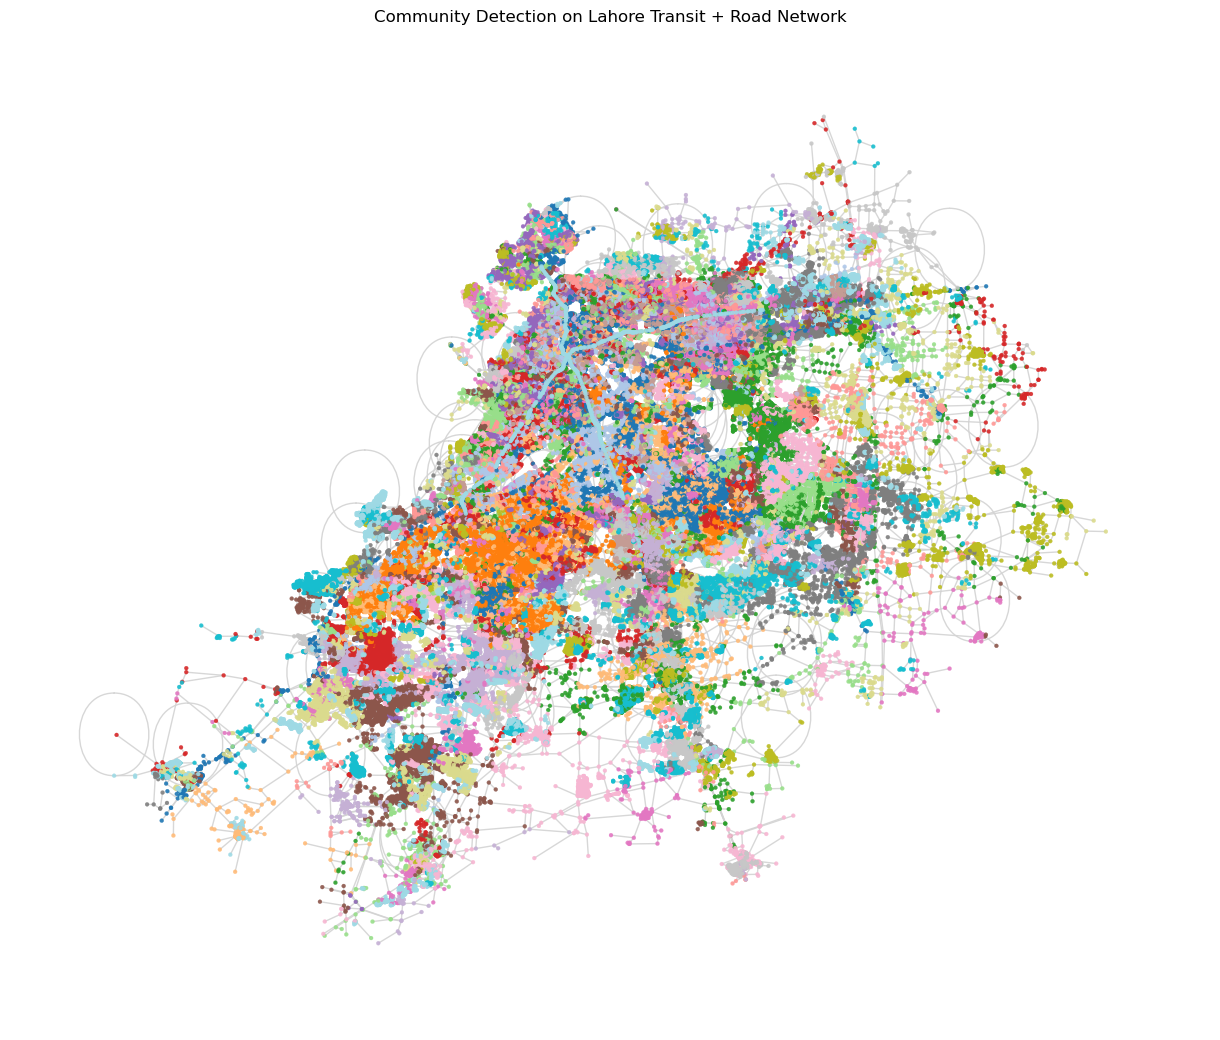

In [4]:
print("Running Label Propagation...")
communities = list(nx.algorithms.community.label_propagation_communities(UG))
print("Total communities found:", len(communities))

node_to_com = {}
for i, com in enumerate(communities):
    for node in com:
        node_to_com[node] = i

colors = [node_to_com[n] for n in UG.nodes()]

# -------------------------------------------------------------
# 6. Plot graph with communities
# -------------------------------------------------------------
plt.figure(figsize=(12, 10))

nx.draw(
    UG,
    pos,
    node_size=8,
    node_color=colors,
    cmap="tab20",
    edge_color="lightgray",
    linewidths=0.2,
    alpha=0.9,
)

plt.title("Community Detection on Lahore Transit + Road Network")
plt.axis("off")
plt.tight_layout()
plt.show()

Detected communities: 272


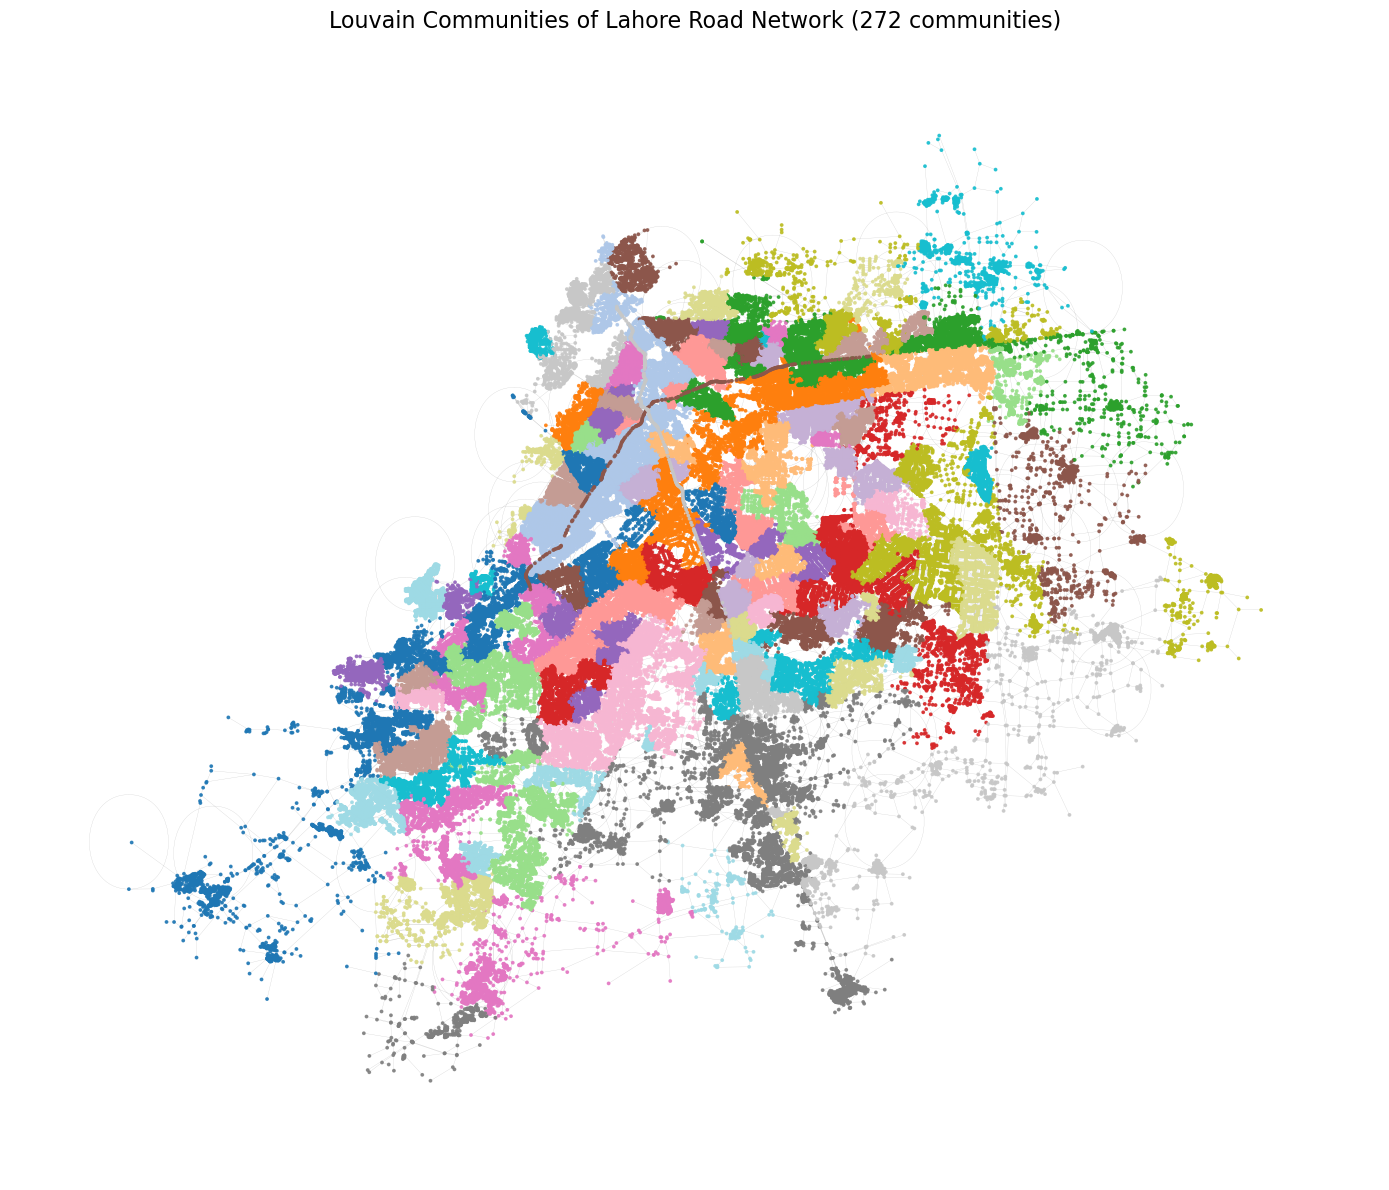

In [5]:
partition = community_louvain.best_partition(UG, resolution=2.0)

nx.set_node_attributes(UG, partition, "community")

num_comms = len(set(partition.values()))
print(f"Detected communities: {num_comms}")

unique_coms = sorted(set(partition.values()))
color_map = {c: i for i, c in enumerate(unique_coms)}
node_colors = [color_map[partition[n]] for n in UG.nodes()]


plt.figure(figsize=(14, 12))
plt.title(
    f"Louvain Communities of Lahore Road Network ({num_comms} communities)", fontsize=16
)

nx.draw_networkx_nodes(
    UG, pos=pos, node_size=3, node_color=node_colors, cmap=plt.cm.tab20, alpha=0.85
)

nx.draw_networkx_edges(UG, pos=pos, width=0.2, edge_color="gray", alpha=0.4)

plt.axis("off")
plt.tight_layout()
plt.show()